In [0]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
! pip install nltk
! pip install gensim
! pip install keras
! pip install sklearn
! pip install pandas
! pip install numpy
! pip install matplotlib

--2019-09-18 19:36:21--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.8.133
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.8.133|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer

from nltk.stem.snowball import SnowballStemmer
import nltk
from nltk.corpus import stopwords
import re
import sys
import warnings

from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, Input, Flatten, Dropout,GlobalMaxPool1D,concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model,Sequential

import gensim
from gensim import models


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
nltk.download('stopwords')
INPUT_URL = "https://zencity.s3.us-east-2.amazonaws.com/311_Cases.csv"
df = pd.read_csv(INPUT_URL)

In [0]:
df.head()

,CaseID,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,Address,Street,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Point,Source,Media URL
0,8446385,12/31/2017 12:00:00 AM,01/05/2018 11:11:00 AM,01/05/2018 11:11:00 AM,Closed,Customer can follow up with Muni Customer Serv...,MUNI Work Queue,MUNI Feedback,MUNI - Conduct_Discourteous_Insensitive_Inappr...,306_General_Unprofessional_Conduct_Appearance,Intersection of HAIGHT ST and MARKET ST,HAIGHT ST,5.0,South of Market,SOUTHERN,37.773037,-122.421944,"(37.77303696, -122.42194366)",Phone,NaN
1,8446381,12/30/2017 11:56:00 PM,01/04/2018 12:52:00 PM,01/04/2018 12:52:00 PM,Closed,Refer to Traffic Signal Shop complaint form 17...,DPT Signal Queue,Damaged Property,Damaged Traffic_Signal,Traffic_Signal,Intersection of FRANKLIN ST and MARKET ST,FRANKLIN ST,6.0,South of Market,SOUTHERN,37.774010,-122.420700,"(37.7740097, -122.42070007)",Phone,NaN
2,8446373,12/30/2017 11:50:00 PM,12/31/2017 12:00:00 AM,12/31/2017 12:00:00 AM,Closed,Request is a duplicate and has been previously...,DPW Ops Queue,Encampments,Encampment Reports,Encampment Cleanup,"1301 CALIFORNIA ST, SAN FRANCISCO, CA, 94109",CALIFORNIA ST,3.0,Nob Hill,CENTRAL,37.791095,-122.415677,"(37.79109466, -122.41567697)",Mobile/Open311,NaN
3,8446358,12/30/2017 11:28:02 PM,04/03/2019 11:45:44 AM,04/03/2019 11:45:44 AM,Closed,"If issue persists, please submit a new service...",Entertainment Commission - G,Noise Report,entertainment,Noise Report - entertainment,"5401 MISSION ST, SAN FRANCISCO, CA, 94112",MISSION ST,11.0,Crocker Amazon,INGLESIDE,37.713647,-122.443391,"(37.7136466, -122.4433905)",Web,NaN
4,8446353,12/30/2017 11:15:00 PM,04/30/2018 12:00:00 AM,04/30/2018 12:00:00 AM,Closed,NaN,DPW Ops Queue,Tree Maintenance,Trees - Landscaping,Other,"1382 47TH AVE, SAN FRANCISCO, CA, 94122",47TH AVE,4.0,Outer Sunset,TARAVAL,37.760759,-122.506970,"(37.76075945, -122.50696974)",Mobile/Open311,http://mobile311.sfgov.org/reports/8446353/photos


In [0]:
df[df.columns.difference(['CaseID','Supervisor District','Latitude','Longitude'])].describe()


,Address,Category,Closed,Media URL,Neighborhood,Opened,Point,Police District,Request Details,Request Type,Responsible Agency,Source,Status,Status Notes,Street,Updated
count,509274,509275,494518,192311,483200,509275,509275,482974,502071,509275,509275,509275,509275,355253,484248,509275
unique,89047,84,409648,192272,117,438505,342874,10,18509,429,248,7,2,113377,2524,423841
top,Not associated with a specific address,Street and Sidewalk Cleaning,11/14/2017 02:56:00 PM,https://sf311.mediafunnel.com/#tabs/43/posts/m...,Mission,09/28/2017 08:43:00 AM,"(0.0, 0.0)",MISSION,Other Loose Garbage,Bulky Items,DPW Ops Queue,Mobile/Open311,Closed,Pickup completed.,MISSION ST,11/14/2017 02:56:00 PM
freq,24992,191946,183,12,52825,25,24856,92278,58541,83344,206001,243959,494518,63377,12660,183


### Checking if there is any repeat/update for a caseID

### Every CaseID is unique. The number of unique cases is equal to the count of the categories

In [0]:
df[['CaseID']].nunique()

CaseID    509275
dtype: int64

# Creating features and understanding the relationships within them

### Displaying the different amounts of requests per district

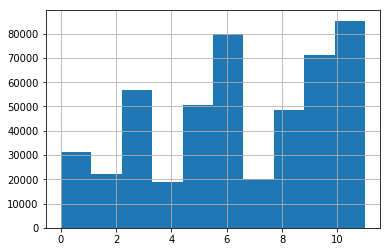

In [0]:
df['Supervisor District'].hist(bins = 10)

### Responsible Agency - will be our target vector.
We would like to check the number of agencies and see if all of them could be predicted/or if there is a bias in the data.

The first Responsible Agency has 10 times more data than the second one - that means the accuracy will have some bias. Another reason is that some of the categories have 1 call. We can see it in the pie chart.

DPW Ops Queue                        206001
Recology_Abandoned                    85327
DPT Abandoned Vehicles Work Queue     30060
MUNI Work Queue                       16071
DPW BSM Queue                         12858
Name: Responsible Agency, dtype: int64

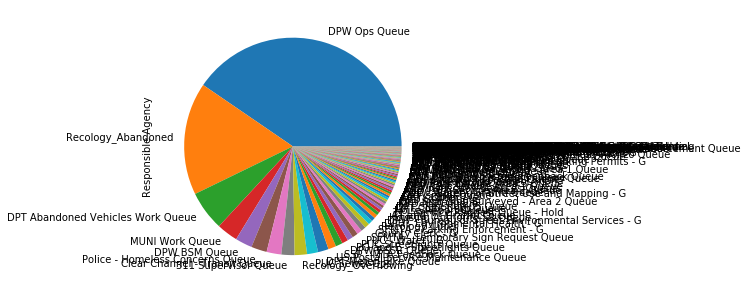

In [0]:
f, ax = plt.subplots(figsize=(16, 5))

df['Responsible Agency'].value_counts().plot(kind = 'pie', ax=ax)
df['Responsible Agency'].value_counts().head()

### Another interesting feature is places with no specific neighborhood (null on Neighborhood column) - we can see that the distribution is different from the above. 

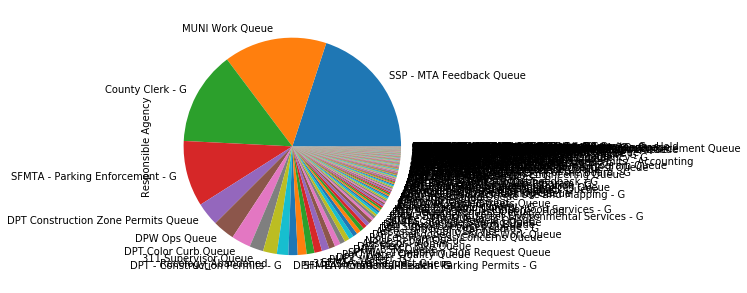

In [0]:
f, ax = plt.subplots(figsize=(16, 5))

df[df['Neighborhood'].isna()]['Responsible Agency'].value_counts().plot(kind = 'pie', ax=ax)

### Merging the agencies under 1000 counts to a different category could be useful in getting better accuracy.

In [0]:
df['main_agency'] = df['Responsible Agency']
replace_agency = df['main_agency'].value_counts()

df['main_agency'] = np.where(df['main_agency'].isin(replace_agency.index[replace_agency < 1000]), 'Other', df['main_agency'])
df['Responsible Agency'].value_counts().tail(10)


Current Events                                       1
RPD Community Services Queue                         1
PUC - Water Waste - Communication Queue              1
HSA - Shelter Reservations Queue                     1
DPT - Meters - G - Hold                              1
DPW - Bureau of Street Use and Mapping - G - Hold    1
Board of Supervisors - District 3 - G                1
Redevelopment Agency - G                             1
TAXI Unpermitted Cab Complaints Queue                1
DPW - Other - G - Hold                               1
Name: Responsible Agency, dtype: int64

### After merging less common agencies we are left with 42 agencies instead of 248. Now, the smallest category has more than 1000 calls.

In [0]:
print(df['main_agency'].nunique())
df['main_agency'].value_counts()

42


DPW Ops Queue                                        206001
Recology_Abandoned                                    85327
DPT Abandoned Vehicles Work Queue                     30060
Other                                                 25615
MUNI Work Queue                                       16071
DPW BSM Queue                                         12858
Police - Homeless Concerns Queue                      11838
Clear Channel - Transit Queue                         11167
311 Supervisor Queue                                   9927
Recology_Overflowing                                   9365
PUC Sewer Ops                                          8363
DPT Meter_Bike Queue                                   8032
US Postal Service Maintenance Queue                    5981
SSP - MTA Feedback Queue                               5308
DPW BSSR Queue                                         4631
PG and E - Streetlights Queue                          4344
PUC Streetlights Queue                  

### Without the small agencies we can see that from the 3rd place on we have similar counts.

42
248
25615


RPD Park Service Area 2 Queue    1278
DBI Inspection Services Queue    1213
RPD Park Service Area 1 Queue    1082
DPW BUF Queue                    1055
RPD Park Service Area 3 Queue    1036
Name: main_agency, dtype: int64

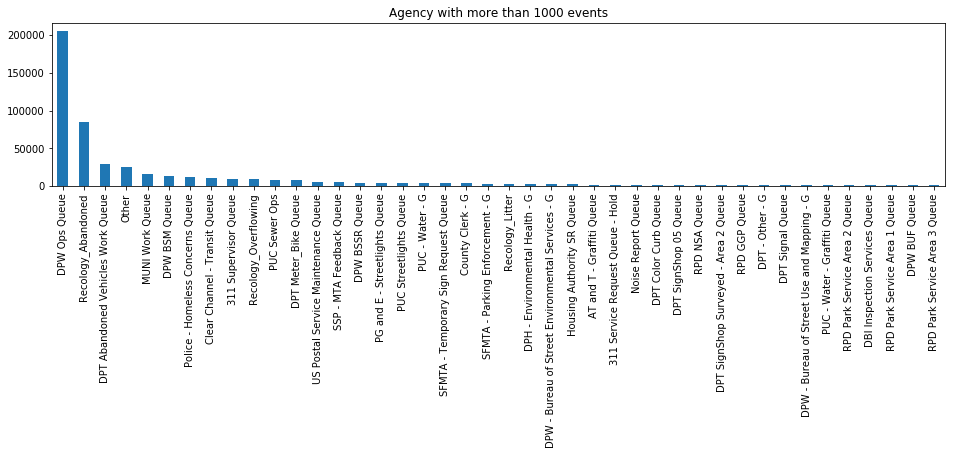

In [0]:
f, ax = plt.subplots(figsize=(16, 3))

df['main_agency'].value_counts().plot(kind='bar', ax=ax)
print(df['main_agency'].nunique())
print(df['Responsible Agency'].nunique())

print(df[df['main_agency']=='Other'].shape[0])
ax.set_title('Agency with more than 1000 events')
df['main_agency'].value_counts().tail()


### By absorbing the nan values we can understand which column could be a good candidate for feature engineering. 

In [0]:
 df.isna().sum()

CaseID                      0
Opened                      0
Closed                  14757
Updated                     0
Status                      0
Status Notes           154022
Responsible Agency          0
Category                    0
Request Type                0
Request Details          7204
Address                     1
Street                  25027
Supervisor District     25026
Neighborhood            26075
Police District         26301
Latitude                    0
Longitude                   0
Point                       0
Source                      0
Media URL              316964
main_agency                 0
dtype: int64

### Which categories are usually closed? 

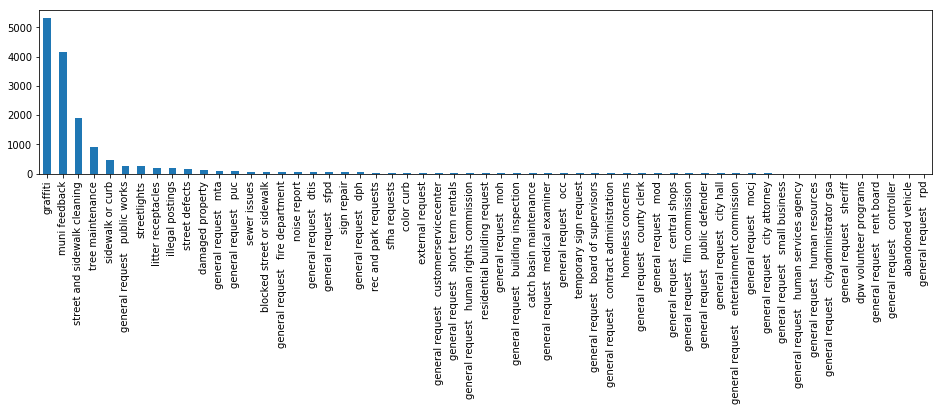

In [0]:
f, ax = plt.subplots(figsize=(16, 3))

df[df['Status'] != 'Closed']['Category'].value_counts().plot(kind='bar', ax=ax)

### Are there typical 311's for different hours? what are the most common hours civilians call 311? lets check...

In [0]:
df['Opened_date'] = pd.to_datetime(df['Opened'])
df['Opened_hour'] = df['Opened_date'].dt.round("H").dt.time


### Top 100 agencies sorted by opening case hours 

In [0]:
agency_hour = df.groupby(['Opened_hour','main_agency']).agg({'Category':'count'}).Category.nlargest(100).sort_index()

In [0]:
agency_hour.head(24)

Opened_hour  main_agency                      
00:00:00     DPW Ops Queue                         1578
01:00:00     DPW Ops Queue                         1023
05:00:00     Recology_Abandoned                    1262
06:00:00     DPW Ops Queue                         2064
             Recology_Abandoned                    2136
07:00:00     Clear Channel - Transit Queue          889
             DPT Abandoned Vehicles Work Queue     1002
             DPW Ops Queue                         7418
             Recology_Abandoned                    3795
08:00:00     Clear Channel - Transit Queue          879
             DPT Abandoned Vehicles Work Queue     2050
             DPW Ops Queue                        15741
             MUNI Work Queue                        816
             Other                                 1522
             Police - Homeless Concerns Queue       897
             Recology_Abandoned                    7199
09:00:00     Clear Channel - Transit Queue          911
 

### Counting events per hour


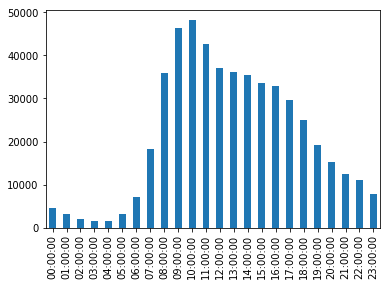

In [0]:
df['Opened_hour'].value_counts().sort_index().plot(kind='bar')

In [0]:
df[df['Closed'].isna()].head()

,CaseID,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,Address,Street,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Point,Source,Media URL,main_agency,Opened_date,Opened_hour
123,8445976,12/30/2017 06:35:00 PM,NaN,05/29/2019 01:25:20 AM,Open,accepted,DPW BSM Queue,Sidewalk or Curb,Missing_Side_Sewer_Vent_Cover,Missing_Side_Sewer_Vent_Cover,"30 SPARTA ST, SAN FRANCISCO, CA, 94134",SPARTA ST,10.0,Visitacion Valley,INGLESIDE,37.717749,-122.403928,"(37.7177489, -122.4039284)",Web,NaN,DPW BSM Queue,2017-12-30 18:35:00,19:00:00
288,8445538,12/30/2017 03:22:00 PM,NaN,12/30/2017 03:55:03 PM,Open,accepted,DPW BUF Queue,Tree Maintenance,Trees - Landscaping,Sprinkler_system_issues,Intersection of VERMONT ST and 20TH ST,VERMONT ST,10.0,Potrero Hill,BAYVIEW,37.759560,-122.404007,"(37.75955963, -122.40400696)",Phone,NaN,DPW BUF Queue,2017-12-30 15:22:00,15:00:00
322,8445444,12/30/2017 02:55:00 PM,NaN,01/05/2018 09:00:03 AM,Open,accepted,DPW Ops Queue,Graffiti,Graffiti on Building_other,Building_other - Not_Offensive,"660 JACKSON ST, SAN FRANCISCO, CA, 94133",JACKSON ST,3.0,Chinatown,CENTRAL,37.796200,-122.406143,"(37.7961998, -122.40614319)",Integrated Agency,NaN,DPW Ops Queue,2017-12-30 14:55:00,15:00:00
323,8445442,12/30/2017 02:55:00 PM,NaN,01/05/2018 10:30:03 AM,Open,accepted,DPW Ops Queue,Graffiti,Graffiti on Building_other,Building_other - Not_Offensive,"4743 MISSION ST, SAN FRANCISCO, CA, 94112",MISSION ST,11.0,Excelsior,INGLESIDE,37.722366,-122.436340,"(37.72236633, -122.43634033)",Integrated Agency,NaN,DPW Ops Queue,2017-12-30 14:55:00,15:00:00
678,8444503,12/30/2017 10:27:00 AM,NaN,01/17/2018 10:20:06 AM,Open,accepted,DPW Ops Queue,Graffiti,Graffiti on Building_other,Building_other - Not_Offensive,"661 JACKSON ST, SAN FRANCISCO, CA, 94133",JACKSON ST,3.0,Chinatown,CENTRAL,37.795994,-122.406097,"(37.7959938, -122.40609741)",Integrated Agency,NaN,DPW Ops Queue,2017-12-30 10:27:00,10:00:00


### Understanding the relationship between null discrict to Responsible Agency by plotting the top 25 agencies.  

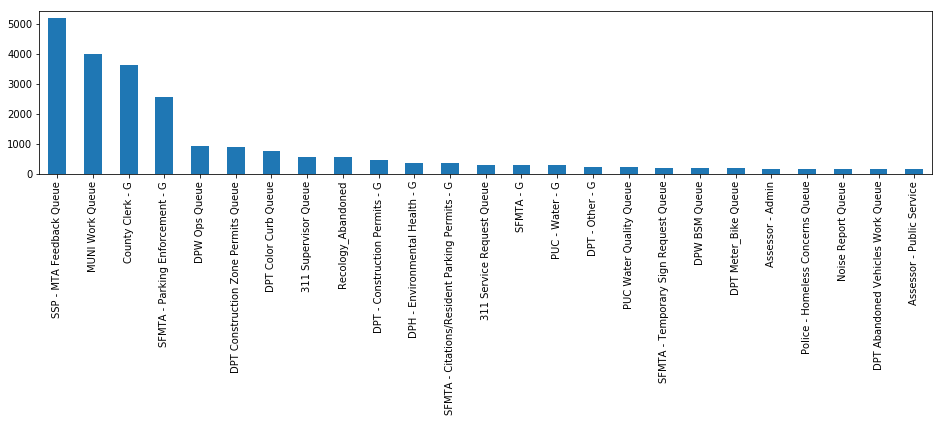

In [0]:
f, ax = plt.subplots(figsize=(16, 3))

df[df['Police District'].isna()]['Responsible Agency'].value_counts().nlargest(25).plot(kind= 'bar',ax=ax)

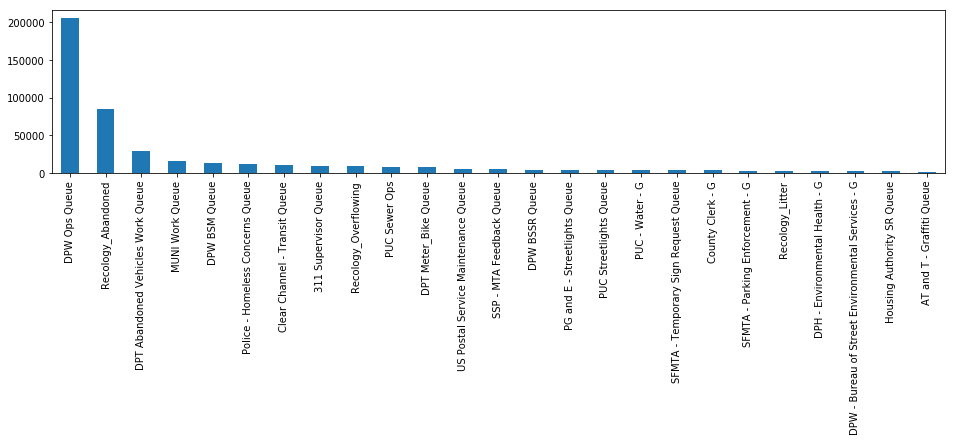

In [0]:
f, ax = plt.subplots(figsize=(16, 3))

df['Responsible Agency'].value_counts().nlargest(25).plot(kind= 'bar',ax=ax)

### We can see that the "Updated" time and the "Closed" time are equal when "Closed" time is not null. 

### the "Handling" time is the time passed between the "Updated" and the "Opened" columns. It could be a good feature, but it might be also a data leak between input and output (knowing that the "Handling" time indicates that the request was already handled).

#### (spoiler alert: the metadata wasn't so important - but it might be, with better architecture).

In [0]:
df['Handling_time'] = (pd.to_datetime(df['Updated']) - pd.to_datetime(df['Opened'])).astype('timedelta64[h]')

We are dealing with 2017's data - an "Updated" time later to the year of 2017 should get the max time which is 1 year in hours. 

In [0]:
df['Handling_time'] = np.where(df['Handling_time']>=8760, 8760, df['Handling_time'])

### Scaling the time between "Opened" and "Updated". 

In [0]:
scaler = MinMaxScaler()
handling_time_scaled = pd.DataFrame(scaler.fit_transform(df[['Handling_time']]))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb6fc79cb70>]],
      dtype=object)

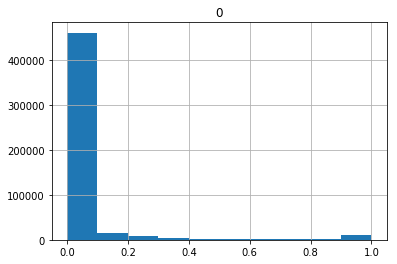

In [0]:
handling_time_scaled.hist()

In [0]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r'[.|,|)|(|\|/]',' ')
    df[text_field] = df[text_field].str.replace(r'[?|_|;|!|\'|"|#|-]',' ')
    df[text_field] = df[text_field].str.replace("\n"," ")
    df[text_field] = df[text_field].str.replace("\d+", "")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

In [0]:
standardize_coulmns = ['Status Notes','Category',	'Request Type',	'Request Details']
for i in standardize_coulmns:
  df = standardize_text(df, i)
  
df.head()

### Creating a dataframe with the features shown above.

In [0]:
df_feature = pd.DataFrame()
df_feature['Supervisor District'] = df['Supervisor District'].fillna(-1) # there are some non realated districts 
df_feature['case_stat'] = pd.get_dummies(df['Status'],drop_first=True)
df_feature['Opened_hour'] = df['Opened'].apply(lambda x: int(x[10:13])/24)
df_feature['text'] = df['Status Notes'].fillna('').astype(str) + ' '+ df['Category'].astype(str) +' '+	df['Request Type'].astype(str)+' '+df['Request Details'].astype(str)

In [0]:
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)

def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)
  
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence
df_feature['text'] = df_feature['text'].apply(removeStopWords)
df_feature['text'] = df_feature['text'].apply(stemming)
df_feature['text'] = df_feature['text'].apply(tokenizer.tokenize)

In [0]:
word2vec = models.KeyedVectors.load_word2vec_format(
    'GoogleNews-vectors-negative300.bin.gz', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = df_feature['text'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [0]:
embeddings = get_word2vec_embeddings(word2vec, df_feature['text'])

In [0]:
all_words = [word for tokens in df_feature['text'] for word in tokens]
VOCAB = sorted(list(set(all_words)))

### We can use LabelBinarizer before the train, test split because there is a limited amount of categories and departments.

### A better approach would be Cat2vec to capture the sentiment of each category and department so an event of misclassification could yield relevant results.
#### Please find link below:
https://blog.myyellowroad.com/using-categorical-data-in-machine-learning-with-python-from-dummy-variables-to-deep-category-42fd0a43b009

In [0]:
lb_M_Agency = LabelBinarizer().fit(df['main_agency'])
lb_R_Agency = LabelBinarizer().fit(df['Responsible Agency'])

In [0]:
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = len(VOCAB)

tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(df_feature['text'].tolist())
sequences = tokenizer.texts_to_sequences(df_feature['text'].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels_alt = lb_M_Agency.transform(df['main_agency'])
labels = lb_R_Agency.transform(df['Responsible Agency'])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

Found 18878 unique tokens.
(18879, 300)


### For the models to include the metadata, we need to add the text data.

In [0]:
df_feature['text'] = cnn_data.tolist()

### The first model will work only on the text column.

In [0]:
def ConvNet1(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)
    
    model = Sequential()    
    main_input = model.add(embedding_layer)
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Dropout(0.2))
    model.add(GlobalMaxPool1D())
    model.add(Dense(10, activation='relu'))

    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    main_output = model.add(Dense(labels_index, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

### Second model combines metadata with the text column so we can try achieving better accuracy. 

In [0]:
def ConvNet2(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)


    main_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(main_input)    
    l_conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    x = Dropout(0.2)(l_conv)
    x = GlobalMaxPool1D()(l_conv)
    x = Dense(10, activation='relu')(x)
    
    auxiliary_input = Input(shape=(3,))
    x = concatenate([x, auxiliary_input])
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)

    main_output = Dense(labels_index, activation='softmax')(x)

    model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output])


    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

In [0]:
X_train, X_test, y_train, y_test = train_test_split(cnn_data, labels, test_size=0.2, 
                                                                                random_state=40)
model = ConvNet1(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, 
                labels.shape[1], False)
model.fit(X_train, y_train, epochs=10, batch_size=128)

Epoch 1/10
407420/407420 [==============================] - 19s 46us/step - loss: 0.6788 - acc: 0.8496
Epoch 2/10
407420/407420 [==============================] - 18s 43us/step - loss: 0.4358 - acc: 0.8965
Epoch 3/10
407420/407420 [==============================] - 18s 43us/step - loss: 0.3964 - acc: 0.9041
Epoch 4/10
407420/407420 [==============================] - 18s 44us/step - loss: 0.3750 - acc: 0.9090
Epoch 5/10
407420/407420 [==============================] - 18s 44us/step - loss: 0.3593 - acc: 0.9120
Epoch 6/10
407420/407420 [==============================] - 18s 44us/step - loss: 0.3472 - acc: 0.9148
Epoch 7/10
407420/407420 [==============================] - 18s 44us/step - loss: 0.3389 - acc: 0.9163
Epoch 8/10
407420/407420 [==============================] - 18s 44us/step - loss: 0.3332 - acc: 0.9178
Epoch 9/10
407420/407420 [==============================] - 18s 44us/step - loss: 0.3268 - acc: 0.9190
Epoch 10/10
407420/407420 [==============================] - 18s 43us/ste

In [0]:
 X_train, X_test, y_train, y_test = train_test_split(df_feature, labels, test_size=0.2, 
                                                                                random_state=40)

In [0]:
model = ConvNet2(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, 
                labels.shape[1], False)
model.fit([np.stack(X_train['text'].values), X_train.drop(columns='text')], y_train, epochs=10, batch_size=128)

Epoch 1/10
407420/407420 [==============================] - 19s 47us/step - loss: 0.6284 - acc: 0.8599
Epoch 2/10
407420/407420 [==============================] - 18s 44us/step - loss: 0.3963 - acc: 0.9048
Epoch 3/10
407420/407420 [==============================] - 18s 44us/step - loss: 0.3565 - acc: 0.9135
Epoch 4/10
407420/407420 [==============================] - 18s 43us/step - loss: 0.3325 - acc: 0.9185
Epoch 5/10
407420/407420 [==============================] - 18s 44us/step - loss: 0.3170 - acc: 0.9216
Epoch 6/10
407420/407420 [==============================] - 18s 44us/step - loss: 0.3053 - acc: 0.9239
Epoch 7/10
407420/407420 [==============================] - 18s 45us/step - loss: 0.2958 - acc: 0.9260
Epoch 8/10
407420/407420 [==============================] - 18s 44us/step - loss: 0.2888 - acc: 0.9275
Epoch 9/10
407420/407420 [==============================] - 18s 44us/step - loss: 0.2826 - acc: 0.9293
Epoch 10/10
407420/407420 [==============================] - 18s 44us/ste

In [0]:
y_pred = model.predict([np.stack(X_test['text'].values), X_test.drop(columns='text')])
y_pred_transform = lb_R_Agency.inverse_transform(y_pred)
y_test_transform = lb_R_Agency.inverse_transform(y_test)
print('classification_report')
print(classification_report(y_test_transform,y_pred_transform))

classification_report


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


                                                               precision    recall  f1-score   support

                             311 Escalated KB Questions Queue       0.00      0.00      0.00         1
                                  311 Escalation Review Queue       0.80      0.89      0.84        18
                                            311 Manager Queue       0.00      0.00      0.00        15
                                    311 Service Request Queue       0.67      0.76      0.71       147
                             311 Service Request Queue - Hold       0.81      0.92      0.86       368
                                         311 Supervisor Queue       0.74      0.58      0.65      1964
                                    AT and T - Graffiti Queue       0.91      0.96      0.93       439
                                 Aging and Adult Services - G       0.17      0.33      0.22         3
                     Airport, San Francisco International - G       0.00

### Third model combines metadata with the text column (similar to modle No. 2) and is aiming to predict the smaller group of agencies "main agency" so we can achieve better accuracy. 

In [0]:
 X_train, X_test, y_train, y_test = train_test_split(df_feature, labels_alt, test_size=0.2, 
                                                                                random_state=40)
model = ConvNet2(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, 
                labels_alt.shape[1], False)
model.fit([np.stack(X_train['text'].values), X_train.drop(columns='text')], y_train, epochs=10, batch_size=128)
y_pred = model.predict([np.stack(X_test['text'].values), X_test.drop(columns='text')])
y_pred_transform = lb_R_Agency.inverse_transform(y_pred)
y_test_transform = lb_R_Agency.inverse_transform(y_test)
print('classification_report')
print(classification_report(y_test_transform,y_pred_transform))

Epoch 1/10
407420/407420 [==============================] - 19s 46us/step - loss: 0.4911 - acc: 0.8762
Epoch 2/10
407420/407420 [==============================] - 18s 43us/step - loss: 0.2919 - acc: 0.9240
Epoch 3/10
407420/407420 [==============================] - 17s 43us/step - loss: 0.2577 - acc: 0.9327
Epoch 4/10
407420/407420 [==============================] - 17s 43us/step - loss: 0.2408 - acc: 0.9365
Epoch 5/10
407420/407420 [==============================] - 17s 43us/step - loss: 0.2293 - acc: 0.9392
Epoch 6/10
407420/407420 [==============================] - 18s 43us/step - loss: 0.2201 - acc: 0.9413
Epoch 7/10
407420/407420 [==============================] - 18s 44us/step - loss: 0.2133 - acc: 0.9433
Epoch 8/10
407420/407420 [==============================] - 18s 43us/step - loss: 0.2079 - acc: 0.9447
Epoch 9/10
407420/407420 [==============================] - 17s 43us/step - loss: 0.2031 - acc: 0.9459
Epoch 10/10
407420/407420 [==============================] - 17s 43us/ste

### Forth model is applied to the text column (similar to model No. 1) aiming to predict the smaller group of agencies "main agency" with Random Forest - as requested in the instructions. It has surprisingly good results. 

In [0]:
from sklearn.ensemble import RandomForestClassifier

X_train_word2vec, X_test_word2vec, y_train, y_test = train_test_split(cnn_data, df['main_agency'], test_size=0.2, 
                                                                                random_state=40)
forest = RandomForestClassifier(n_estimators = 100)

print("Fitting a random forest to labeled training data...")
forest = forest.fit(X_train_word2vec, y_train)

Fitting a random forest to labeled training data...


In [0]:
y_predicted_word2vec = forest.predict(X_test_word2vec)
print('classification_report')
print(classification_report(y_test,y_predicted_word2vec))

classification_report
                                                   precision    recall  f1-score   support

                 311 Service Request Queue - Hold       0.86      0.89      0.87       368
                             311 Supervisor Queue       0.77      0.49      0.60      1964
                        AT and T - Graffiti Queue       0.97      0.97      0.97       439
                    Clear Channel - Transit Queue       0.99      0.96      0.97      2205
                                 County Clerk - G       0.97      0.99      0.98       739
                    DBI Inspection Services Queue       0.92      0.92      0.92       236
                   DPH - Environmental Health - G       0.95      0.94      0.94       575
                                  DPT - Other - G       0.86      0.82      0.84       298
                DPT Abandoned Vehicles Work Queue       0.99      0.99      0.99      5920
                             DPT Color Curb Queue       0.98      0